In [1]:
# imports
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [2]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', path='m6405Ri.pt')

Using cache found in /home/moaz/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-1 Python-3.8.15 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1060 with Max-Q Design, 6072MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [3]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
CLASS_NAMES_DICT[0]

'cuval'

In [4]:
SOURCE_VIDEO_PATH = 'video_sacks.mp4'
TARGET_VIDEO_PATH = 'result' + SOURCE_VIDEO_PATH

In [5]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=1)

In [6]:
# get first video frame
for i in range(50):
    iterator = iter(generator)
    frame = next(iterator)

In [7]:
# model prediction on single frame
results = model(frame, size=1280)
print(results)

image 1/1: 1080x1920 1 cuval
Speed: 18.0ms pre-process, 67.3ms inference, 14.7ms NMS per image at shape (1, 3, 736, 1280)


In [8]:
# model predictions to supervision Detections
detections = Detections(
    xyxy=results.xyxy[0][:, :-2].cpu().numpy(),
    confidence=results.xyxy[0][:, -2].cpu().numpy(),
    class_id=results.xyxy[0][:, -1].cpu().numpy().astype(int)
)

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {conf:.2f}"
    for _, conf, class_id, _
    in detections
]

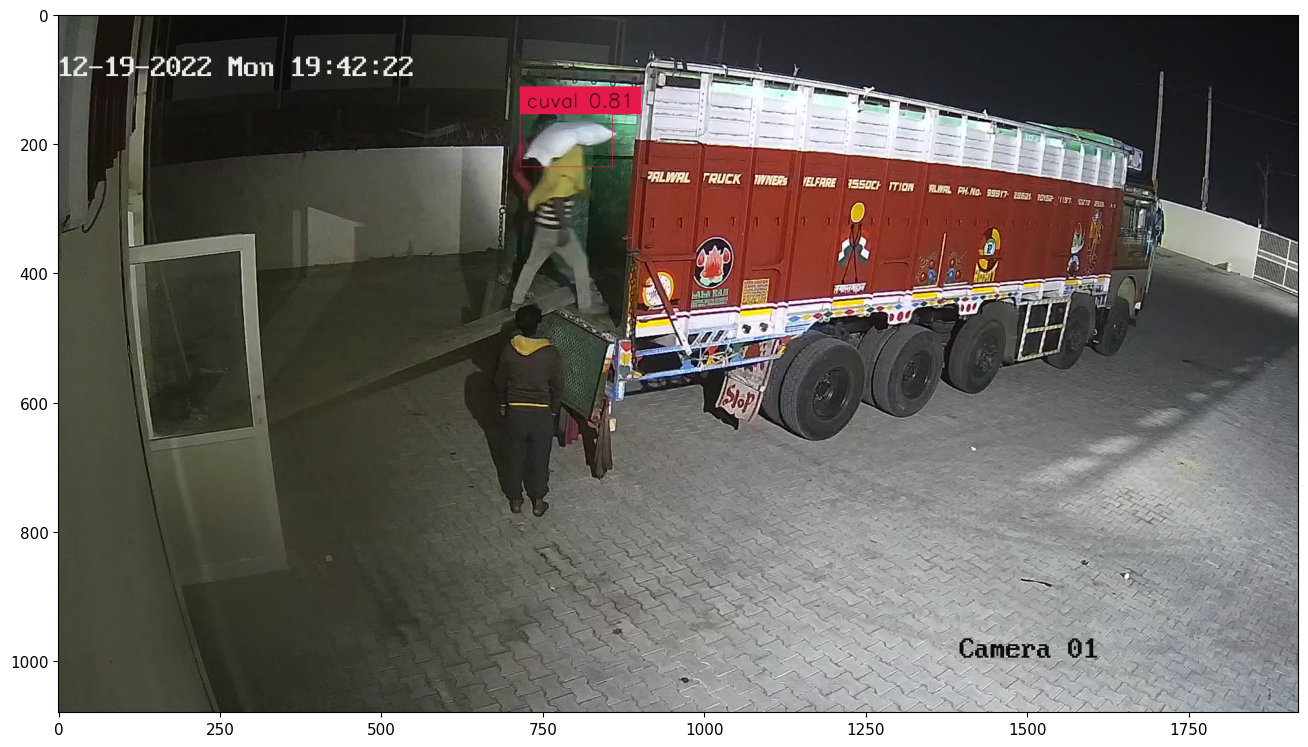

In [9]:
# annoate and display frame
%matplotlib inline
frame_ = frame
frame_ = box_annotator.annotate(frame=frame_, detections=detections, labels=labels)
show_frame_in_notebook(frame_, (16, 16))

In [10]:
# settings (line location)
LINE_START = Point(700, 0)
LINE_END = Point(700, 1000)

vid_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
vid_info

VideoInfo(width=1920, height=1080, fps=25, total_frames=4725)

In [11]:
import numpy as np

In [12]:
from tqdm.notebook import tqdm

from deep_sort_realtime.deepsort_tracker import DeepSort

# initiate the tracker
object_tracker = DeepSort(max_age=20,
                n_init=2,
                nms_max_overlap=1.0,
                max_cosine_distance=0.3,
                nn_budget=None,
                override_track_class=None,
                embedder="mobilenet",
                half=True,
                bgr=True,
                embedder_gpu=True,
                embedder_model_name=None,
                embedder_wts=None,
                polygon=False,
                today=None)

# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

In [13]:
x_shape, y_shape = video_info.width, video_info.height
def xyxyn_to_wh(row):
    x1, y1, x2, y2 = int(row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)
    return ([x1, y1, int(x2-x1), int(y2-y1)])

In [14]:
# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame, size=1280)
        
        results_ = results.xyxyn[0].cpu().numpy()
        
        
        

        # tracking detections
        dets = [(xyxyn_to_wh(det), conf, i) for det, conf, i in zip(results_[:, :-2],
                                                                    results_[:, -2],
                                                                    results_[:, -1])]
        if dets:
            tracks = object_tracker.update_tracks(dets, frame=frame)

            track_confs = [track.get_det_conf() for track in tracks]
            track_classes = [track.get_det_class() for track in tracks]
            track_ids = [track.track_id for track in tracks]
            mask = [track.get_det_conf() != None for track in tracks]
            track_dets = [track.to_tlbr() for track in tracks]

            if len(track_dets) > 0:

                detections = Detections(
                    xyxy       = np.array(track_dets),
                    confidence = np.array(track_confs),
                    class_id   = np.array(track_classes).astype(int),
                    tracker_id = np.array(track_ids)
                )

                # filter not confirmed
                detections.filter(mask=mask, inplace=True)   

                
                # format custom labels
                labels = [
                    f"#ID:{tracker_id}"
                    for _, _, _, tracker_id
                    in detections
                ]
                # updating line counter
                line_counter.update(detections=detections)
                # annotate and display frame
                frame = box_annotator.annotate(frame=frame, detections=detections)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/4725 [00:00<?, ?it/s]